In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from collections import Counter
import random
import matplotlib.pyplot as plt

### Action and Reward

In [2]:
ACTIONS = {'ROCK': 0, 'PAPER': 1, 'SCISSORS': 2}
ACTION_NAMES = {v: k for k, v in ACTIONS.items()}
NUM_ACTIONS = len(ACTIONS)

def get_reward(agent_action, opponent_action):
    """가위바위보 게임의 보상을 계산합니다."""
    if agent_action == opponent_action:
        return 0  # 무승부
    elif (agent_action == ACTIONS['ROCK'] and opponent_action == ACTIONS['SCISSORS']) or \
         (agent_action == ACTIONS['PAPER'] and opponent_action == ACTIONS['ROCK']) or \
         (agent_action == ACTIONS['SCISSORS'] and opponent_action == ACTIONS['PAPER']):
        return 1  # 승리
    else:
        return -1 # 패배

### Opponent Strategy

In [3]:
class ConstantOpponent:
    """항상 동일한 행동을 하는 상대방입니다."""
    def __init__(self, constant_action_name='ROCK'):
        self.action = ACTIONS[constant_action_name]

    def choose_action(self, agent_actions_history=None):
        return self.action

class RandomOpponent:
    """무작위로 행동을 선택하는 상대방입니다."""
    def choose_action(self, agent_actions_history=None):
        return random.choice(list(ACTIONS.values()))

class CountingOpponent:
    """에이전트가 가장 자주 한 행동을 이기는 행동을 하는 상대방입니다."""
    def choose_action(self, agent_actions_history):
        if not agent_actions_history:
            return random.choice(list(ACTIONS.values())) # 초기에는 무작위

        agent_most_common_action = Counter(agent_actions_history).most_common(1)[0][0]

        if agent_most_common_action == ACTIONS['ROCK']:
            return ACTIONS['PAPER']  # 바위를 이기는 보
        elif agent_most_common_action == ACTIONS['PAPER']:
            return ACTIONS['SCISSORS'] # 보를 이기는 가위
        else: # SCISSORS
            return ACTIONS['ROCK']   # 가위를 이기는 바위

### Environment

In [4]:
class RPSEnv:
    """가위바위보 환경입니다."""
    def __init__(self, opponent_strategy):
        self.opponent = opponent_strategy
        self.agent_actions_this_episode = []
        self.is_counting_opponent = isinstance(self.opponent, CountingOpponent)

    def reset(self):
        """환경을 초기화하고 초기 상태를 반환합니다."""
        self.agent_actions_this_episode = []
        if self.is_counting_opponent:
            # CountingOpponent의 경우 상태는 에이전트의 행동 분포 (초기에는 0)
            return torch.zeros(NUM_ACTIONS, dtype=torch.float32)
        else:
            # 다른 상대방의 경우 더미 상태 (예: 0)
            return torch.tensor([0.0], dtype=torch.float32)

    def step(self, agent_action):
        """에이전트의 행동을 받아 다음 상태, 보상, 종료 여부를 반환합니다."""
        self.agent_actions_this_episode.append(agent_action)
        
        opponent_action = self.opponent.choose_action(self.agent_actions_this_episode if self.is_counting_opponent else None)
        reward = get_reward(agent_action, opponent_action)

        if self.is_counting_opponent:
            next_state = self._get_agent_action_distribution_state()
        else:
            next_state = torch.tensor([0.0], dtype=torch.float32) # 더미 상태 유지
        
        return next_state, reward, opponent_action

    def _get_agent_action_distribution_state(self):
        """현재 에피소드에서 에이전트의 행동 분포를 상태로 반환합니다."""
        if not self.agent_actions_this_episode:
            return torch.zeros(NUM_ACTIONS, dtype=torch.float32)
        
        counts = Counter(self.agent_actions_this_episode)
        distribution = torch.tensor([counts.get(i, 0) for i in range(NUM_ACTIONS)], dtype=torch.float32)
        return distribution / torch.sum(distribution) if torch.sum(distribution) > 0 else torch.zeros(NUM_ACTIONS, dtype=torch.float32)

### Policy Network

In [5]:
class PolicyNet(nn.Module):
    """에이전트의 정책을 결정하는 신경망입니다."""
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1) # 행동 확률 출력
        return x

### Policy Gradient Agent

In [6]:
class PolicyGradientAgent:
    """REINFORCE 알고리즘을 사용하는 정책 경사 에이전트입니다."""
    def __init__(self, input_size, hidden_size, output_size, lr, gamma):
        self.policy_net = PolicyNet(input_size, hidden_size, output_size)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma

        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        """주어진 상태에서 정책에 따라 행동을 선택하고 로그 확률과 엔트로피를 저장합니다."""
        probs = self.policy_net(state)
        m = Categorical(probs)
        action = m.sample()
        
        self.log_probs.append(m.log_prob(action))
        return action.item()

    def store_reward(self, reward):
        self.rewards.append(reward)

    def update_policy(self):
        """수집된 보상과 로그 확률을 사용하여 정책을 업데이트합니다."""
        if not self.log_probs:
            return 0.0 # 업데이트할 데이터 없음

        discounted_rewards = []
        R = 0
        for r in reversed(self.rewards): # 에피소드의 끝 보상부터 시작
            R = r + self.gamma * R       # G_t = r_t + gamma * G_{t+1}
            discounted_rewards.insert(0, R)
        
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)

        policy_loss = []
        for log_prob, R in zip(self.log_probs, discounted_rewards):
            policy_loss.append(-log_prob * R)
        
        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        self.optimizer.step()

        # 다음 에피소드를 위해 기록 초기화
        episode_loss = loss.item()
        self.log_probs = []
        self.rewards = []
        return episode_loss

### Train

In [7]:
def train(opponent_name, opponent_strategy, input_size, hidden_size, num_actions, lr, gamma, num_episodes, steps_per_episode):
    """주어진 상대 전략에 대해 에이전트를 훈련합니다."""
    print(f"\n--- {opponent_name} 상대 훈련 시작 ---")
    
    env = RPSEnv(opponent_strategy)
    agent = PolicyGradientAgent(input_size, hidden_size, num_actions, lr, gamma)
    
    episode_total_rewards = []
    episode_losses = []

    for episode in range(num_episodes):
        state = env.reset()
        current_episode_total_reward = 0
        
        for step in range(steps_per_episode):
            action = agent.select_action(state)
            next_state, reward, opponent_action = env.step(action)
            
            agent.store_reward(reward)
            current_episode_total_reward += reward
            state = next_state
            

        loss = agent.update_policy()
        episode_losses.append(loss)
        episode_total_rewards.append(current_episode_total_reward)

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_total_rewards[-100:])
            avg_loss = np.mean(episode_losses[-100:]) if episode_losses else 0
            print(f"에피소드 {episode+1}/{num_episodes}, 최근 100 에피소드 평균 보상: {avg_reward:.2f}, 평균 손실: {avg_loss:.4f}")

    print(f"--- {opponent_name} 상대 훈련 종료 ---")
    return episode_total_rewards

### Main Process

In [8]:
# 하이퍼파라미터
LEARNING_RATE = 0.001
GAMMA = 0.99
HIDDEN_SIZE = 64
NUM_EPISODES = 2000  # 에피소드 수
STEPS_PER_EPISODE = 50 # 에피소드 당 스텝 수

all_results = {}

# 1. 고정 전략 상대 (바위만 내는 상대)
opponent_constant_rock = ConstantOpponent(constant_action_name='ROCK')
# 고정/랜덤 상대의 경우 상태는 더미(1차원)
input_size_constant_random = 1
rewards_constant = train(
    opponent_name="항상 바위(Constant Rock)",
    opponent_strategy=opponent_constant_rock,
    input_size=input_size_constant_random,
    hidden_size=HIDDEN_SIZE,
    num_actions=NUM_ACTIONS,
    lr=LEARNING_RATE,
    gamma=GAMMA,
    num_episodes=NUM_EPISODES,
    steps_per_episode=STEPS_PER_EPISODE
)
all_results["Constant Rock"] = rewards_constant

# 2. 카운팅 기반 전략 상대
opponent_counting = CountingOpponent()
# 카운팅 상대의 경우 상태는 에이전트 행동 분포 (NUM_ACTIONS 차원)
input_size_counting = NUM_ACTIONS
rewards_counting = train(
    opponent_name="카운팅 기반(Counting-based)",
    opponent_strategy=opponent_counting,
    input_size=input_size_counting,
    hidden_size=HIDDEN_SIZE,
    num_actions=NUM_ACTIONS,
    lr=LEARNING_RATE,
    gamma=GAMMA,
    num_episodes=NUM_EPISODES,
    steps_per_episode=STEPS_PER_EPISODE
)
all_results["Counting-based"] = rewards_counting

# 3. 균등 랜덤 전략 상대
opponent_random = RandomOpponent()
# 고정/랜덤 상대의 경우 상태는 더미(1차원)
rewards_random = train(
    opponent_name="균등 랜덤(Uniform Random)",
    opponent_strategy=opponent_random,
    input_size=input_size_constant_random, # 고정/랜덤 상대와 동일한 더미 상태
    hidden_size=HIDDEN_SIZE,
    num_actions=NUM_ACTIONS,
    lr=LEARNING_RATE,
    gamma=GAMMA,
    num_episodes=NUM_EPISODES,
    steps_per_episode=STEPS_PER_EPISODE
)
all_results["Uniform Random"] = rewards_random

print("\n모든 훈련이 완료되었습니다.")


--- 항상 바위(Constant Rock) 상대 훈련 시작 ---
에피소드 100/2000, 최근 100 에피소드 평균 보상: 23.82, 평균 손실: 421.9024
에피소드 200/2000, 최근 100 에피소드 평균 보상: 38.46, 평균 손실: 477.0777
에피소드 300/2000, 최근 100 에피소드 평균 보상: 44.17, 평균 손실: 319.1149
에피소드 400/2000, 최근 100 에피소드 평균 보상: 46.77, 평균 손실: 230.5241
에피소드 500/2000, 최근 100 에피소드 평균 보상: 45.80, 평균 손실: 281.2296
에피소드 600/2000, 최근 100 에피소드 평균 보상: 47.08, 평균 손실: 216.0620
에피소드 700/2000, 최근 100 에피소드 평균 보상: 47.94, 평균 손실: 157.4655
에피소드 800/2000, 최근 100 에피소드 평균 보상: 49.08, 평균 손실: 89.3791
에피소드 900/2000, 최근 100 에피소드 평균 보상: 49.21, 평균 손실: 77.3094
에피소드 1000/2000, 최근 100 에피소드 평균 보상: 48.92, 평균 손실: 100.5709
에피소드 1100/2000, 최근 100 에피소드 평균 보상: 48.78, 평균 손실: 102.3977
에피소드 1200/2000, 최근 100 에피소드 평균 보상: 48.83, 평균 손실: 104.6913
에피소드 1300/2000, 최근 100 에피소드 평균 보상: 49.08, 평균 손실: 83.5792
에피소드 1400/2000, 최근 100 에피소드 평균 보상: 49.11, 평균 손실: 78.5069
에피소드 1500/2000, 최근 100 에피소드 평균 보상: 49.27, 평균 손실: 77.8960
에피소드 1600/2000, 최근 100 에피소드 평균 보상: 48.92, 평균 손실: 97.6544
에피소드 1700/2000, 최근 100 에피소드 평균 보상: 49.07, 평균 손실:

### 결과 시각화

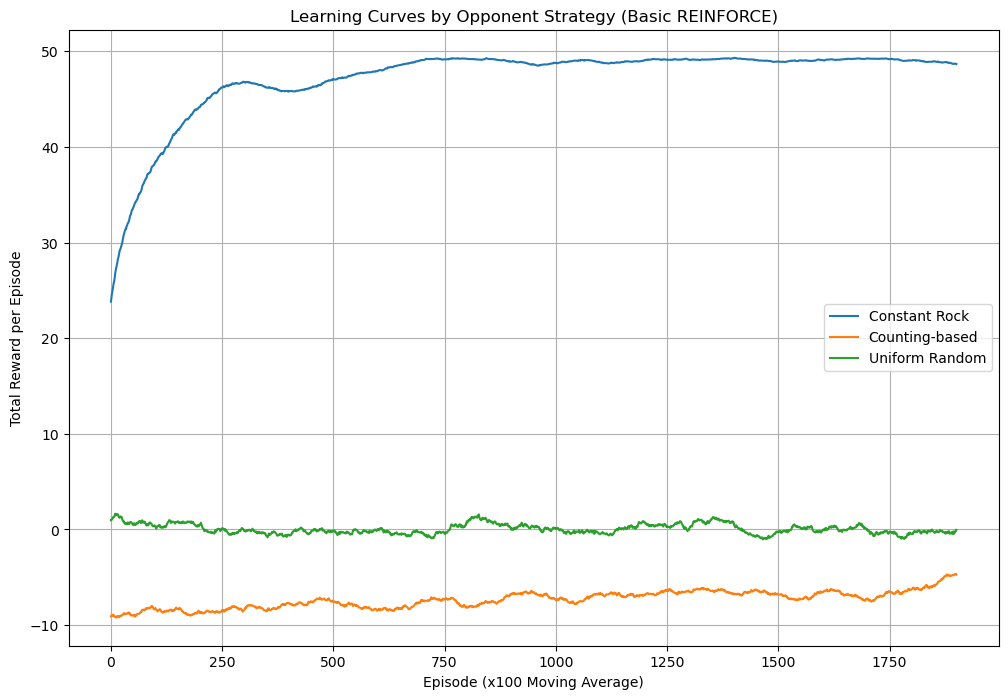

In [9]:
plt.figure(figsize=(12, 8))
for name, rewards in all_results.items():
    # 이동 평균으로 부드럽게 표시
    moving_avg_rewards = np.convolve(rewards, np.ones(100)/100, mode='valid')
    plt.plot(moving_avg_rewards, label=name)
plt.xlabel("Episode (x100 Moving Average)")
plt.ylabel("Total Reward per Episode")
plt.title("Learning Curves by Opponent Strategy (Basic REINFORCE)")
plt.legend()
plt.grid(True)
plt.show()

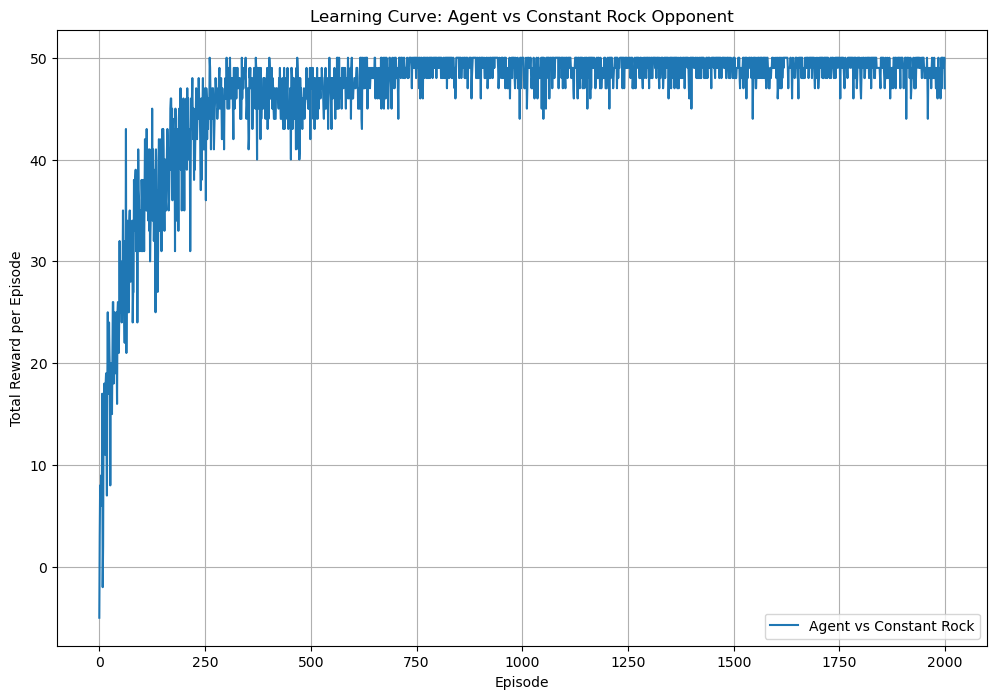

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(all_results['Constant Rock'], label='Agent vs Constant Rock')
plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.title("Learning Curve: Agent vs Constant Rock Opponent")
plt.legend()
plt.grid(True)
plt.show()

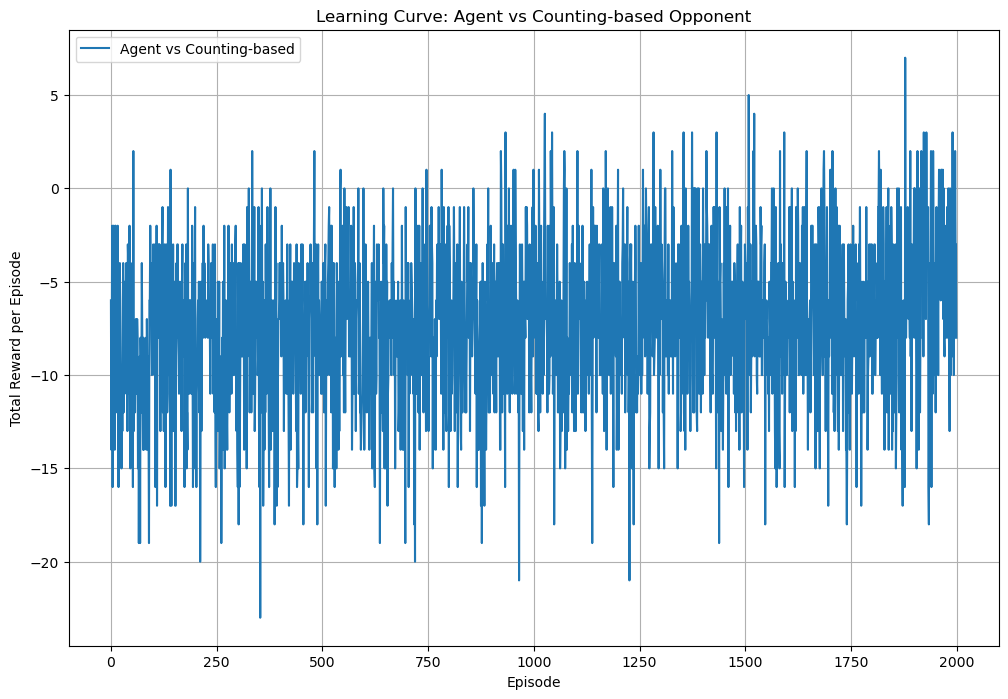

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(all_results['Counting-based'], label='Agent vs Counting-based')
plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.title("Learning Curve: Agent vs Counting-based Opponent")
plt.legend()
plt.grid(True)
plt.show()

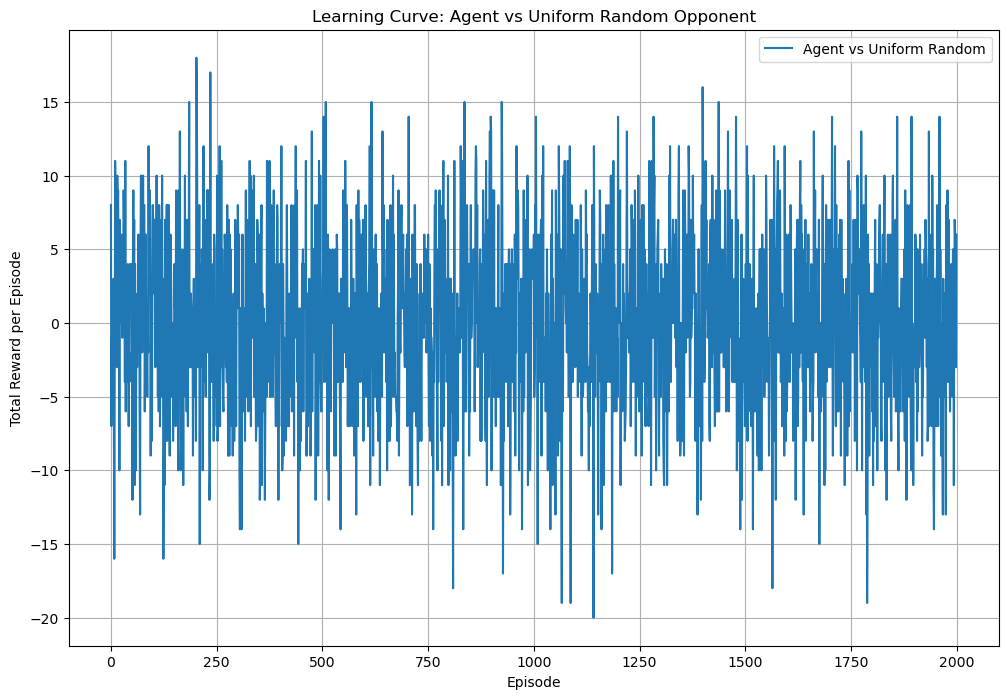

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(all_results['Uniform Random'], label='Agent vs Uniform Random')
plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.title("Learning Curve: Agent vs Uniform Random Opponent")
plt.legend()
plt.grid(True)
plt.show()